In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import LineString, Polygon
from shapely.ops import linemerge
from utils import EarthquakeCatalog
from sklearn.neighbors import BallTree
from scipy.stats import bootstrap
import scipy.io
from typing import Callable, Optional, List
import os
import math
import pyproj
import obspy

## If this causes issues you can comment it out and set decluster to False
from utils import Catalog
from stat_utils import get_bvalue, get_bpositive, get_clustered_fraction, bootstrap_statistic, bootstrap_df, jitter
from decluster import time_torchETAS_decluster as decluster

In [2]:
font = {"size": 8}
matplotlib.rc("font", **font)
matplotlib.rc("figure", dpi=200)

## TODO: 

- [x] Look at the ~2010 sequence M_w7
- [x] Check date ranges for NUMBER OF PERIODS
- [x] narrow down the study area
- [x] Seasonal variations in the sections subject to the highest load changes.
- [x] ZZ for the normalized seismicity rate
- [ ] sinusoidal point process model for the background seismicity
- [ ] a-positive


## Analysis of seismicity along the North Atlantic spreading ridge

### Overview

The analysis roughly follows the these steps:

* Get shapefile for spreading ridge
* Upsample at desired point spacing
* get corresponding earthquake catalog
* get k-nearest earthquakes at each point along spreading ridge
* calculate statistics:
  * b-value (b+)
  * a-value
* get the modelled strai
* get spatially averaged strain along the same section
* correlate statistics to strain rate

Subsequent analysis:
* remove trends associated to spreading rate and faulting style 
* clustrered vs. declustered
* record major geological features along the spreading ridge (e.g. iceland, major earthquakes, etc)


### Useful litterature

Note that an analysis was loosely inspired (although it has since diverged significantly) by the workflow in:

*A unified perspective of seismicity and fault coupling along the San Andreas Fault*

https://www.science.org/doi/full/10.1126/sciadv.abk1167?fbclid=IwAR2HdRzrYRcHJaV3LrciFyn0m-9RpNZ20oOmbagbXI176iIFLSaHxj3LiUk&intcmp=trendmd-adv&adobe_mc=MCMID%3D22100252661862915997832685880766884763%7CMCORGID%3D242B6472541199F70A4C98A6%2540AdobeOrg%7CTS%3D1652659200

In a quick literature review it seems like some of this analysis has already been done:

*Ice melting and earthquake suppression in Greenland*

https://www.sciencedirect.com/science/article/pii/S1873965214000681#bib3

Relavant litterature and resouces:

Here is a relatively detailed record of the seismic network in the polar region:

https://www.ngdc.noaa.gov/mgg/avetisov/CHAP1.htm

A catalog more or less complete to M4.5 in 1965!

Lynn R. Sykes; The seismicity of the Arctic. Bulletin of the Seismological Society of America 1965;; 55 (2): 501–518. doi: https://doi.org/10.1785/BSSA0550020501

Analysis of sesimicity along the entrie atlantic spreading ridge: 

Estimation of the Tapered Gutenberg-Richter Distribution Parameters for Catalogs with Variable Completeness: An Application to the Atlantic Ridge Seismicity

Appl. Sci. 2021, 11(24), 12166; https://doi.org/10.3390/app112412166


## Required Files and Metadata

In [37]:
data_dir = "data/"

plate_boundary_metadata = {
    "filename": "plate_boundaries/PB2002_boundaries.shp",
    "boundary": ["NA-EU", "EU-NA"],
}

earthquake_catalog_metadata = {
    "ISC": {
        "filename": "north_atlantic_catalog.csv",
        "magnitude_cutoff": 4.5,
        "starttime": "1992-01-01",
        "endtime": "2022-01-01",
        "buffer": 4,
    },
    "decluster": False,
    "reload": True,
}

earthquake_metadata = earthquake_catalog_metadata["ISC"]  # Option here

AVAILABLE_STRAIN_RATE_FILES = {
    "november22": "november_22/strain.mat",
    "febuary23_thick": "febuary_23/yearly_strain_rate_tensors_l90ump5lm3_smoothice.mat",
    "febuary23_thin": "febuary_23/yearly_strain_rate_tensors_l40um5_18lm3_smoothice.mat",
    "febuary23_2d": "febuary_23/yearly_strain_rate_tensors_l90ump5lm3_smoothice_2D_WDEG1.mat",   # only horizonatal stains are available,
    "april23_thin": "April23/Full Strain Tensors w Smoothing/yearly_strain_rate_tensors_l40um5_18lm3_smoothice_S.mat",
    "april23_thick": "April23/Full Strain Tensors w Smoothing/yearly_strain_rate_tensors_l90ump5lm3_smoothice_S.mat",
    "april23_long_term": "April23/Background Long Term GIA Strains/presentday_strain_rate_tensors_l90ump5lm3_ICE6G_S.mat",
}

GrGIA_strain_metadata = {
    "filename": AVAILABLE_STRAIN_RATE_FILES["april23_thin"],
    "data_key": "strain_out", # unfortunately this is not consistent accross datasets.
    "starttime": 1993,
    "endtime": 2020,
    "number_of_times": 27,
    "latitude_range": [-90, 90],
    "number_of_latitudes": 510,
    "longitude_range": [-180, 180],
    "number_of_longitudes": 1022,
    "strain_units": [1e-9, "s^{-1}"],  # scale, unit
    "strain_positive_convestion": "compression",
    "add_long_term_strain": False, 
}

crs = ccrs.NorthPolarStereo()

exclude_iceland = True


## The north atlantic spreading ridge

In [38]:
# read in the boundaries file:
plate_boundaries = gpd.read_file(
    os.path.join(data_dir, plate_boundary_metadata["filename"])
)

# get the north selected plate boundary:
north_antlantic_plate_boundary = plate_boundaries.iloc[
    np.logical_or.reduce(
        [
            plate_boundaries.Name == boundary
            for boundary in plate_boundary_metadata["boundary"]
        ]
    )
]

bounds =  Polygon([(-180, 55), (-180, 90), (10, 90), (10, 55), (-180, 55)])
north_antlantic_plate_boundary = north_antlantic_plate_boundary.clip(bounds).explode()

if exclude_iceland:
    # remove iceland from the plate boundary
    iceland_bounds =gpd.GeoSeries([Polygon([(-25, 55), (-25, 68), (-13, 68), (-13, 55), (-25, 68)])])
    iceland_bounds_df = gpd.GeoDataFrame({'geometry': iceland_bounds})
    north_antlantic_plate_boundary = gpd.overlay(north_antlantic_plate_boundary, iceland_bounds_df, how='difference').explode()

# crs are always a bit confusing: here we set axis and boundary geometry to
# the same north polar stereographic projection
crs_proj4 = crs.proj4_init
na_pb = north_antlantic_plate_boundary.geometry.to_crs(crs_proj4)

# Entering Coordinate reference system hell: proceed with caution

def densify_geometry(line_geometry, step, crs_in=None, crs_out=None):
    # crs: epsg code of a coordinate reference system you want your line to be georeferenced with
    # step: add a vertice every step in whatever unit your coordinate reference system use.

    length_m = line_geometry.length  # get the length

    xy = []  # to store new tuples of coordinates

    for distance_along_old_line in np.arange(0, int(length_m), step):
        point = line_geometry.interpolate(
            distance_along_old_line
        )  # interpolate a point every step along the old line
        xp, yp = point.x, point.y  # extract the coordinates

        xy.append((xp, yp))  # and store them in xy list

    new_line = LineString(
        xy
    )  # Here, we finally create a new line with densified points.

    if (
        crs_in != None
    ):  #  If you want to georeference your new geometry, uses crs to do the job.
        new_line_geo = gpd.geoseries.GeoSeries(new_line, crs=crs_in)

    if crs_out != None:
        new_line_geo = new_line_geo.to_crs(crs_out)
        return new_line_geo

    else:
        return new_line

crs_in = crs_proj4
crs_out = "EPSG:4326"

PLATE_BOUNDARY_STEP_SIZE = 50000 # meters (the point spacing of the plate boundary)

boundary_in_meters = north_antlantic_plate_boundary.to_crs(crs_in)
merged_boundary_in_meters = linemerge(boundary_in_meters.geometry.values)
interp_merged_boundary = densify_geometry(
    merged_boundary_in_meters,
    PLATE_BOUNDARY_STEP_SIZE,
    crs_in=crs_in,
    crs_out=crs_out,
).geometry.values[0]

/Users/kdascher/miniforge3/envs/torch_earthquake_stat/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/3530331264.py:17: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  north_antlantic_plate_boundary = north_antlantic_plate_boundary.clip(bounds).explode()
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/3530331264.py:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the

## Get earthquakes for the corresponding region

In [5]:
# The following loads in the catalog for the corresponding region. Note that this workflow is a bit awkward near the pole so we end up getting more events than is actually needed. 
# If the catalog was already downloaded, and you may wish to skip this cell. Otherwise the workflow defers to what is in the metadata.

bound_buffer = earthquake_metadata["buffer"] * np.array([-1, -1, 1, 1])
bounds = np.array(north_antlantic_plate_boundary.total_bounds) + bound_buffer

print(
    "Total bounds of the selected plate boundary:\n{}".format(
        bounds,
    )
)

# Todo: assert that metadata has not change
if earthquake_catalog_metadata["reload"] is True:
    EarthquakeCatalog.get_and_save_catalog(
        filename=os.path.join(data_dir, earthquake_metadata["filename"]),
        starttime=earthquake_metadata["starttime"],
        endtime=earthquake_metadata["endtime"],
        latitude_range=bounds[1:4:2],
        longitude_range=bounds[0:3:2],
        minimum_magnitude=earthquake_metadata["magnitude_cutoff"],
    )

Total bounds of the selected plate boundary:
[-39.33612251  51.          14.          89.0094    ]


In [6]:
assert os.path.isfile(
    os.path.join(data_dir, earthquake_metadata["filename"])
), "Catalog file not found, consider reloading catalog"

catalog = pd.read_csv(
    os.path.join(data_dir, earthquake_metadata["filename"]), na_values=" None"
)

catalog = EarthquakeCatalog._add_time_column(catalog, "time")
catalog = catalog.sort_values(by="time", ascending=True, ignore_index=True)

In [7]:
EARTH_RADIUS = 6371  # km

def radius_search(points, queries, radius) -> list[list]:
    """Searches for points within a radius of a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric="haversine")
    return tree.query_radius(
        np.deg2rad(queries), r=radius / EARTH_RADIUS, return_distance=False
    )

def k_nearest_search(points, queries, k=1):
    """Searches for the indices of the k nearest points to a query lat lon point and returns a list of corresponding indices."""
    tree = BallTree(np.deg2rad(points), metric="haversine")
    return tree.query(np.deg2rad(queries), k=k)[1]

def get_geometry_neighbors(
    catalog: pd.DataFrame,
    boundary: LineString,
    fun: Callable = radius_search,
    kwarg: dict = {"radius": 200},
    return_unique: bool = False,
):
    """Returns a list of indices of earthquakes that are neighboring the the specified linestring geometry."""

    queries = np.array([boundary.xy[1], boundary.xy[0]]).T
    points = np.array([catalog.lat.to_numpy(), catalog.lon.to_numpy()]).T

    indices = fun(points, queries, **kwarg)

    if return_unique:
        indices = np.unique(np.concatenate(indices))

    return indices


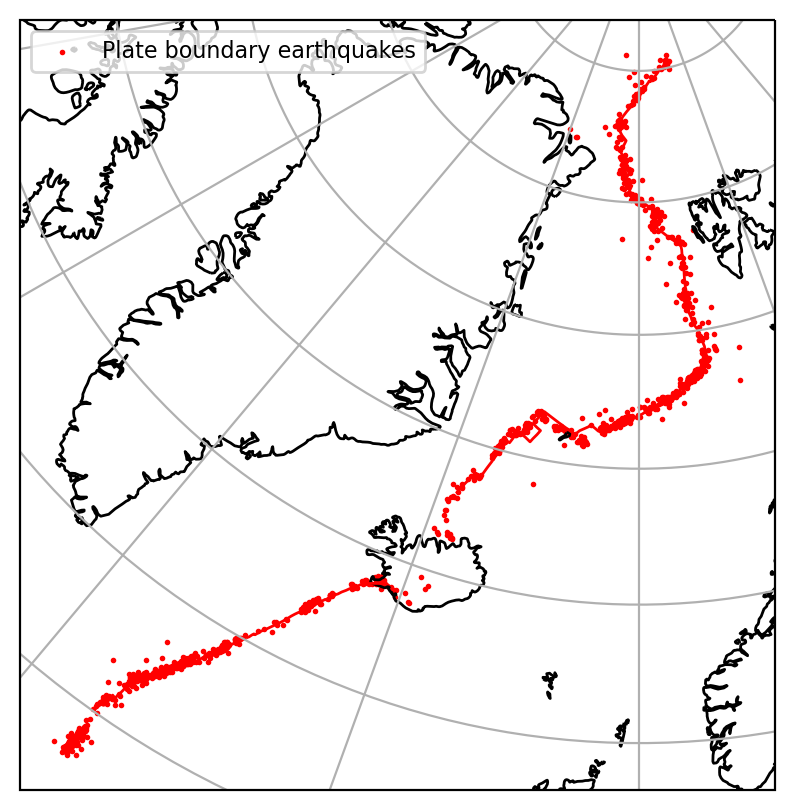

In [8]:
plate_boundary_catalog = catalog.copy()
unique_indices = get_geometry_neighbors(
    catalog,
    interp_merged_boundary,
    fun=radius_search,
    kwarg={"radius": 200},
    return_unique=True,
)
plate_boundary_catalog = plate_boundary_catalog.iloc[unique_indices]

indices = k_nearest_search(
    np.array([interp_merged_boundary.xy[1], interp_merged_boundary.xy[0]]).T,
    plate_boundary_catalog[["lat","lon"]].values
)
plate_boundary_catalog["distance_along_boundary"] = indices*PLATE_BOUNDARY_STEP_SIZE

if earthquake_catalog_metadata["decluster"] is True:

    declustered_catalog = decluster(
        Catalog(plate_boundary_catalog)
    )

    fig, ax = plt.subplots(2,1,sharex=True,sharey=True)
    Catalog(plate_boundary_catalog).plot_time_series(ax=ax[0])
    declustered_catalog.plot_time_series(ax=ax[1])
    plt.tight_layout()

    plate_boundary_catalog = declustered_catalog.catalog

crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(5, 5))
na_pb.plot(ax=ax, color="red", lw=1)
ax.coastlines()
ax.gridlines()
ax.scatter(
    x=plate_boundary_catalog.lon.to_numpy(),
    y=plate_boundary_catalog.lat.to_numpy(),
    transform=ccrs.PlateCarree(),
    color="r",
    s=1,
    label="Plate boundary earthquakes",
)
ax.legend()


[None]

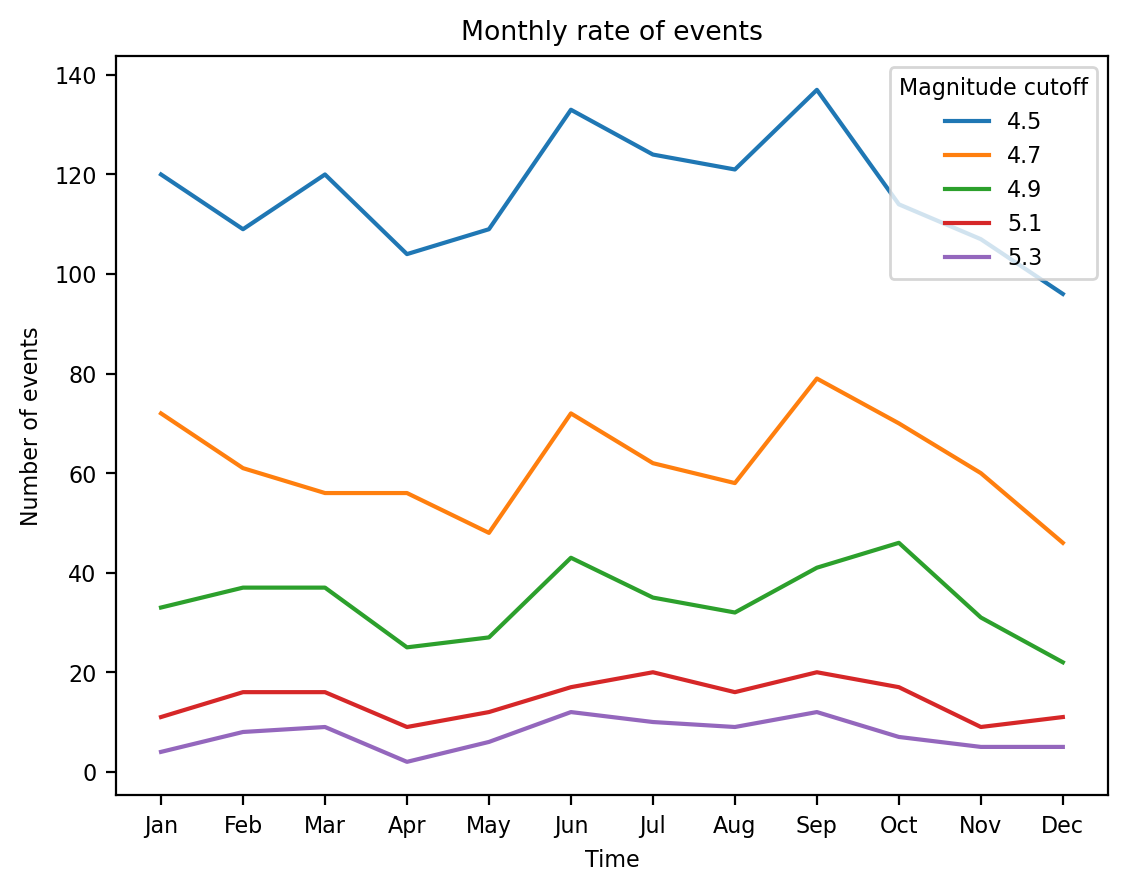

In [9]:


# Check whether there is any monthly modulation in the number of events in the catalog
def plot_monthly_rate(df,ax=None):
    """Using the time column of a catalog, plots the monthly rate of events."""
    df = df.copy()
    df["month"] = df.time.dt.month
    if ax is None:
        fig, ax = plt.subplots()
    df.groupby("month").count()["time"].plot(ax=ax)
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of events")
    ax.set_title("Monthly rate of events")

fig, ax = plt.subplots()

for mc in np.arange(earthquake_catalog_metadata['ISC']['magnitude_cutoff'], 5.5, 0.2):
    plot_monthly_rate(plate_boundary_catalog[plate_boundary_catalog.mag >= mc], ax = ax)
ax.set(
    xticks=np.arange(1,13),
    xticklabels=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
)
lg = ax.legend(["{:.1f}".format(mc) for mc in np.arange(earthquake_catalog_metadata['ISC']['magnitude_cutoff'], 5.5, 0.2)])
lg.set(
    title="Magnitude cutoff",
)

**Figure**: Seasonal variations in seismicity along the North Atlantic spreading ridge. Each line represent on threshold level for the catalog completeness. It may be interesting to see whether there appears to any phase correlation between the seismicity and the seasonal loading of the ice sheet. Note that this plot seems quite sensitive to declustering and varies for each random decluster.

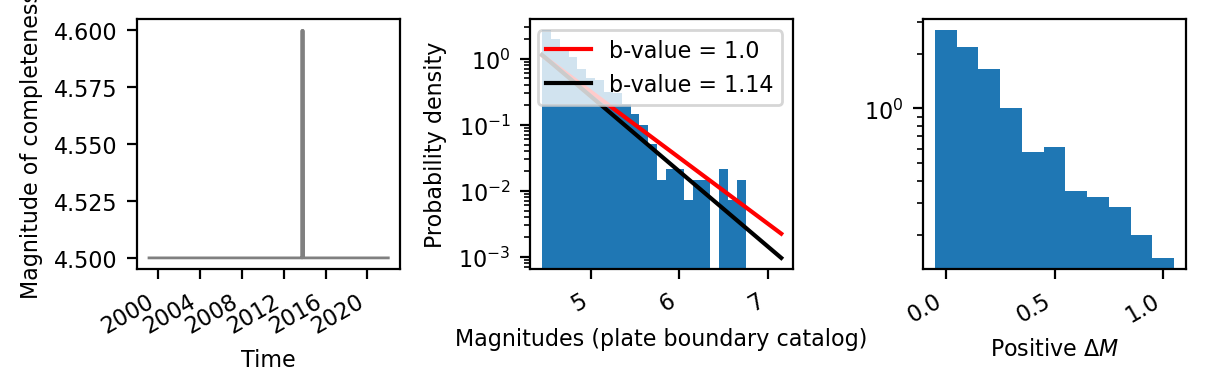

In [10]:
def max_C(x, dx=0.1, correction=0.2):
    """Returns the modal bin of a histogram of x values with bin width dx."""
    counts, bins = np.histogram(x, bins=np.arange(min(x), max(x), dx) - dx / 2)
    return bins[np.argmax(counts)] + dx / 2


fig, AX = plt.subplots(1,3,figsize=(6, 2))
ax = AX[0]
ax.plot(
    plate_boundary_catalog.time.to_numpy(),
    plate_boundary_catalog.mag.rolling(200).apply(max_C),
    color="grey",
    lw=1,
)
ax.set_xlabel("Time")
ax.set_ylabel("Magnitude of completeness")
plt.gcf().autofmt_xdate()


boot = 10000
res = bootstrap_statistic(
    plate_boundary_catalog.mag.to_numpy(),
    lambda x: get_bpositive(x, 0, apply_jitter=True, inc=0.1),
    boot=boot,
)

AX[1].hist(
    plate_boundary_catalog.mag.to_numpy(),
    bins=np.arange(earthquake_metadata["magnitude_cutoff"] - 0.05, 7.2, 0.1),
    log=True,
    density=True,
)

AX[1].set_xlabel("Magnitudes (plate boundary catalog)")
# plot distribution with a b-value of 1.0
AX[1].plot(
    np.arange(earthquake_metadata["magnitude_cutoff"] - 0.05, 7.2, 0.1),
    10
    ** (
        -1.0
        * (
            np.arange(earthquake_metadata["magnitude_cutoff"] - 0.05, 7.2, 0.1)
            - earthquake_metadata["magnitude_cutoff"]
        )
    ),
    color="red",
    label="b-value = 1.0",
)

AX[1].plot(
    np.arange(earthquake_metadata["magnitude_cutoff"] - 0.05, 7.2, 0.1),
    10
    ** (
        -np.mean(res) 
        * (
            np.arange(earthquake_metadata["magnitude_cutoff"] - 0.05, 7.2, 0.1)
            - earthquake_metadata["magnitude_cutoff"]
        )
    ),
    color="k",
    label="b-value = {:.2f}".format(np.mean(res)),
)

AX[1].legend()
AX[1].set_ylabel("Probability density")

AX[2].hist(
    np.diff(plate_boundary_catalog.mag.to_numpy()),
    bins=np.arange(0, 1.2, 0.1) - 0.05,
    log=True,
    density=True,
)
AX[2].set_xlabel("Positive $\Delta M$")
plt.tight_layout();



**Figure**: Temporal evolution of the catalog completeness during the study period. There do appear to be some spikes but the overall the completeness is fairly stable.

Here is a summary of the statistics computed over the entire catalog.

In [11]:
catalog_statistics = {
    "b-value (b-positive)": lambda cat: get_bpositive(
        cat.mag.to_numpy(), 0, apply_jitter=True, inc=0.1
    ),
    "b-value": lambda cat: get_bvalue(
        cat.mag.to_numpy(),
        earthquake_metadata["magnitude_cutoff"],
        apply_jitter=False,
        inc=0.1,
    ),
    "clustered fraction": lambda cat: get_clustered_fraction(cat.time.to_numpy()),
}

## Along strike variations

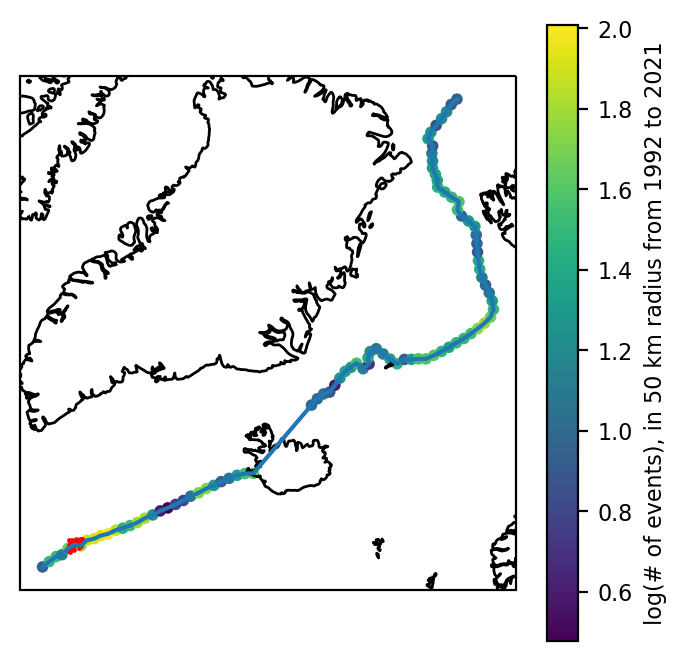

In [12]:
RADIUS = 50  # km
indices = get_geometry_neighbors(
    catalog, interp_merged_boundary, fun=radius_search, kwarg={"radius": RADIUS}
)
rate = [len(i) for i in indices]

crs = ccrs.NorthPolarStereo()
crs_proj4 = crs.proj4_init

fig, ax = plt.subplots(subplot_kw=dict(projection=crs), figsize=(4, 4))
ax.plot(*interp_merged_boundary.xy, transform=ccrs.PlateCarree())
bdr = ax.scatter(
    *interp_merged_boundary.xy, c=np.log10(rate), s=10, transform=ccrs.PlateCarree()
)
ax.coastlines()
plt.colorbar(
    bdr,
    label=f"log(# of events), in {RADIUS} km radius from {catalog.time.min().year} to {catalog.time.max().year}",
)
i = 5
_lat, _lon = np.hsplit(catalog[["lat", "lon"]].iloc[indices[i]].values, 2)
ax.scatter(_lon, _lat, s=0.5, c="r", transform=ccrs.PlateCarree())


**Figure**: Along strike variatiosn in the rate of seismicity along the Mid Atlantic Ridge. Note that the colorbar is log-scaled. In red is an example of the earthquakes within the specified search radius. Crosses are distributed at every 10th equaly spaced point along the boundary.

## Variations in time and space:

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/2495490044.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start=pd.datetime(GrGIA_strain_metadata["starttime"], 1, 1),
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/2495490044.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end=pd.datetime(GrGIA_strain_metadata["endtime"], 1, 1),


365 days 05:20:00


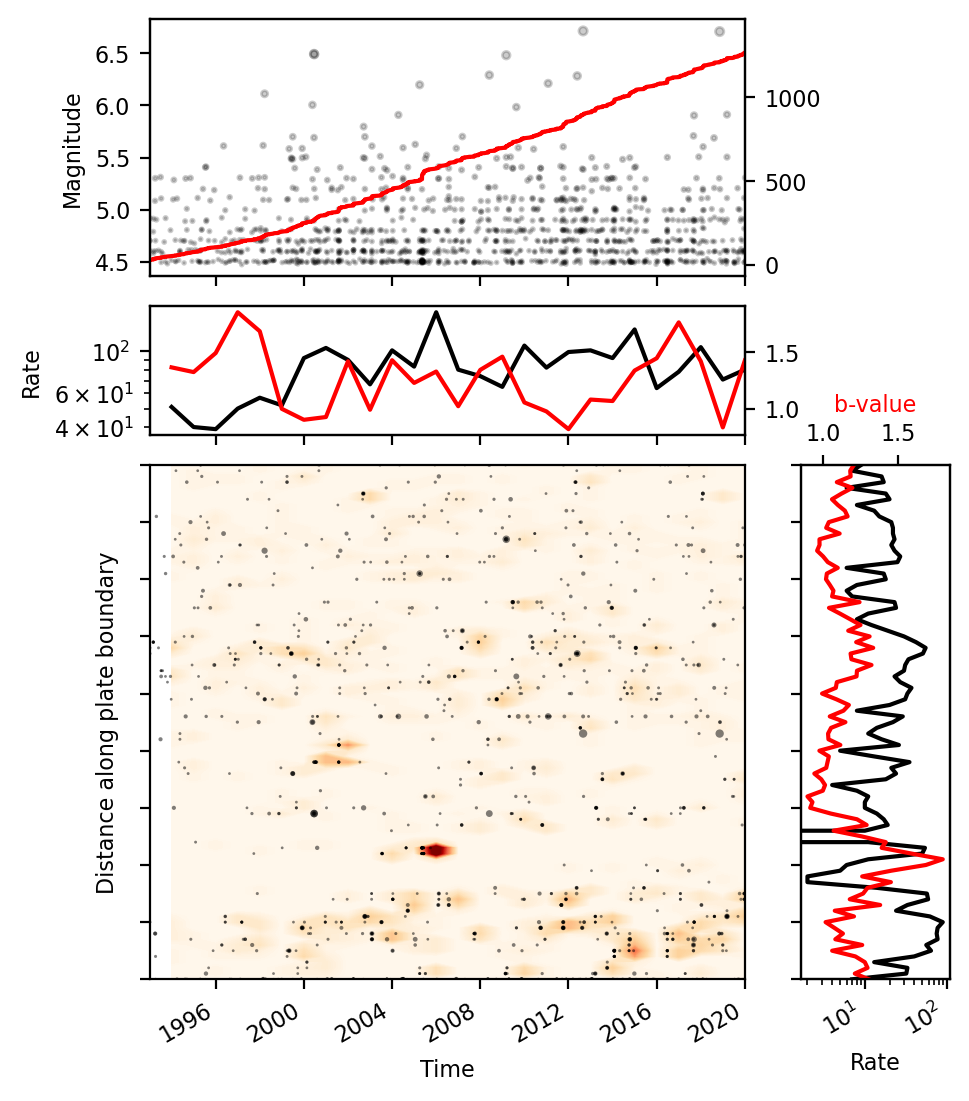

In [13]:
NUMBER_OF_PERIODS = 28  # number of periods to split the catalog into
WINDOW_SIZE = 50  # km
NUMBER_OF_EVENTS = 200

catalog = plate_boundary_catalog

rate_grid = []
b_time = []
all_indices = []

catalog.time.sort_values(ignore_index=True)

date_range = pd.date_range(
    start=pd.datetime(GrGIA_strain_metadata["starttime"], 1, 1),
    end=pd.datetime(GrGIA_strain_metadata["endtime"], 1, 1),
    periods=NUMBER_OF_PERIODS,
)
delta_t = date_range[1] - date_range[0]
print(delta_t)

# Time statistics:
time_statistics = {k: [] for k in catalog_statistics.keys()}

for t1, t2 in zip(date_range[:-1], date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) & (catalog.time > t1)]
    for k, v in catalog_statistics.items():
        time_statistics[k].append(v(sub_catalog))


# Space statistics:
space_statistics = {k: [] for k in catalog_statistics.keys()}


# get the indices of the k nearest neighbors to each point in the boundary
indices = get_geometry_neighbors(
    catalog, interp_merged_boundary, fun=k_nearest_search, kwarg={"k": NUMBER_OF_EVENTS}
)
for indices_for_one_point in indices:
    for k, v in catalog_statistics.items():
        space_statistics[k].append(v(catalog.iloc[indices_for_one_point]))


# Space-time rate:
for t1, t2 in zip(date_range[:-1], date_range[1:]):
    sub_catalog = catalog[(catalog.time < t2) & (catalog.time > t1)]
    indices = get_geometry_neighbors(
        sub_catalog,
        interp_merged_boundary,
        fun=radius_search,
        kwarg={"radius": WINDOW_SIZE},
    )
    all_indices.append(indices)
    rate_grid.append([len(i) for i in indices])

rate_grid = np.array(rate_grid).T

# Begin the plotting
fig = plt.figure(figsize=(5, 6))
gs = fig.add_gridspec(
    3,
    2,
    width_ratios=(4, 1),
    height_ratios=(2, 1, 4),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.15,
    hspace=0.1,
)

ax = fig.add_subplot(gs[2, 0])
ax_seis = fig.add_subplot(gs[0, 0], sharex=ax)
ax_x = fig.add_subplot(gs[1, 0], sharex=ax)
ax_y = fig.add_subplot(gs[2, 1], sharey=ax)

# plot the earthquake catalog
ax_seis.scatter(
    catalog.time.to_numpy(),
    jitter(catalog.mag.to_numpy(), 0.01),
    s=np.exp(
        (
            catalog.mag.to_numpy()
            - earthquake_metadata["magnitude_cutoff"]
        )
    ),
    c="k",
    alpha=0.2,
    edgecolors=None,
)

ax_seis.set_ylabel("Magnitude")

ax_seis_b = ax_seis.twinx()
ax_seis_b.plot(
    catalog.time.to_numpy(),
    np.arange(len(catalog.time.to_numpy())),
    c="r",
)
ax_seis.set_xlim([date_range[0], date_range[-1]])

# plot the rate_grid of events over time
ax_x.plot(date_range[1:], rate_grid.sum(axis=0), c="k")
ax_x.set_yscale("log")
ax_x.set_ylabel("Rate")
ax_x_b = ax_x.twinx()
ax_x_b.plot(date_range[1:], time_statistics["b-value (b-positive)"], c="r")

# plot the rate_grid of events over time and space
max_level = 0.8 * rate_grid.max()
levels = np.linspace(rate_grid.min(), max_level, 100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * PLATE_BOUNDARY_STEP_SIZE/1e3,
    rate_grid,
    levels=levels,
    cmap="OrRd",
    vmax=max_level,
    extend="max",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
)

ax.scatter(
    catalog.time, catalog.distance_along_boundary/1000,
    color='black',
    s=np.exp(
        (
            (catalog.mag.to_numpy()
            - earthquake_metadata["magnitude_cutoff"])
        )
    ),
    lw=0,
    alpha=0.5, 
)


ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
ax.margins(x=0)
plt.gcf().autofmt_xdate()

# plot the rate of events over space
ax_y.plot(rate_grid.sum(axis=1), np.arange(len(rate_grid)) * PLATE_BOUNDARY_STEP_SIZE/1000, c="k")
ax_y.set_yticklabels([])
ax_y.set_xscale("log")
ax_y.set_xlabel("Rate")

ax_y_b = ax_y.twiny()
ax_y_b.plot(
    space_statistics["b-value (b-positive)"],
    np.arange(len(np.column_stack(interp_merged_boundary.xy))) * PLATE_BOUNDARY_STEP_SIZE/1000,
    c="r",
)
ax_y_b.set_xlabel("b-value", color="r");


# Greenland Icesheet Glacial Isostatic Ajustment model output

We can next consider how these rates of seismicity relate to changes in Iceshelf loading over time.

Note that it looks like there is a distinct rate change around 1995. I suspect this is the result of a change in the network.

In [14]:
strain = -1 * scipy.io.loadmat(os.path.join(data_dir, GrGIA_strain_metadata["filename"]))[
    GrGIA_strain_metadata["data_key"]
] # negative sign because the sign convention in the modelling specified expansion as positive, but we want **contraction as positive**

strain = np.flip(
    strain, 1
)  # idk man, life is hard (latitudes were specified in decreasing order)

if GrGIA_strain_metadata["add_long_term_strain"]:
    lt =  -1 * scipy.io.loadmat(os.path.join(data_dir, AVAILABLE_STRAIN_RATE_FILES["april23_long_term"]))[
    GrGIA_strain_metadata["data_key"]
    ] # negative sign because the sign convention in the modelling specified expansion as positive, but we want **contraction as positive**

    lt = np.flip(
        lt, 1
    )  # idk man, life is hard (latitudes were specified in decreasing order)

    strain += lt


assert [
    GrGIA_strain_metadata[k]
    for k in ["number_of_times", "number_of_latitudes", "number_of_longitudes"]
] + [3, 3] == list(
    strain.shape
), "strain data dimensions do not match metadata specification"


In [15]:
strain_years = np.linspace(
    *[GrGIA_strain_metadata[k] for k in ["starttime", "endtime", "number_of_times"]],
)

# Careful about tthe edges of the grid. I am following what seems to be done in the lat.mat and lon.mat files.
strain_latitudes = np.linspace(
    *GrGIA_strain_metadata["latitude_range"],
    GrGIA_strain_metadata["number_of_latitudes"] + 1,
)[1:]

strain_longitudes = np.linspace(
    *GrGIA_strain_metadata["longitude_range"],
    GrGIA_strain_metadata["number_of_longitudes"] + 1,
)[:-1]


def get_data_from_querries(
    times: np.ndarray,
    latitudes: np.ndarray,
    longitudes: np.ndarray,
    dataset: np.ndarray = strain,
    data_times: np.ndarray = strain_years,
    data_latitudes: np.ndarray = strain_latitudes,
    data_longitudes: np.ndarray = strain_longitudes,
) -> np.ndarray:
    time_grid, lat_grid, lon_grid = np.meshgrid(
        data_times, data_latitudes, data_longitudes, indexing="ij"
    )

    tree = BallTree(
        np.column_stack([time_grid.flatten(), lat_grid.flatten(), lon_grid.flatten()])
    )

    querried_indices = tree.query(
        np.column_stack(
            [times, latitudes, longitudes],
        ),
        k=1,
    )[1]

    return strain.reshape(-1, *strain.shape[-2:])[querried_indices, :, :].squeeze()


In [16]:
earthquake_time_dt = pd.to_datetime(catalog.time).dt
strain_at_earthquake_with_time = get_data_from_querries(
    earthquake_time_dt.year + earthquake_time_dt.dayofyear / 365 - 1,
    catalog.lat.to_numpy(),
    catalog.lon.to_numpy(),
)


In [17]:
def unravelled_grid(t, lat, lon):
    time_grid, lat_grid = [q.ravel() for q in np.meshgrid(t, lat)]
    _, lon_grid = [q.ravel() for q in np.meshgrid(t, lon)]
    return np.column_stack([time_grid, lat_grid, lon_grid])


plate_boundary_unravelled_grid = unravelled_grid(
    (date_range.year + (date_range.dayofyear - 1) / 365).values[1:],  # time,
    interp_merged_boundary.xy[1],  # latitudes of the plate boundary
    interp_merged_boundary.xy[0],  # longitudes of the plate boundary
)

strain_at_plate_boundary = get_data_from_querries(
    plate_boundary_unravelled_grid[:, 0],
    plate_boundary_unravelled_grid[:, 1],
    plate_boundary_unravelled_grid[:, 2],
)

strain_at_plate_boundary_grid = np.reshape(
    strain_at_plate_boundary,
    (len(interp_merged_boundary.xy[0]), len(date_range) - 1, 3, 3),
)


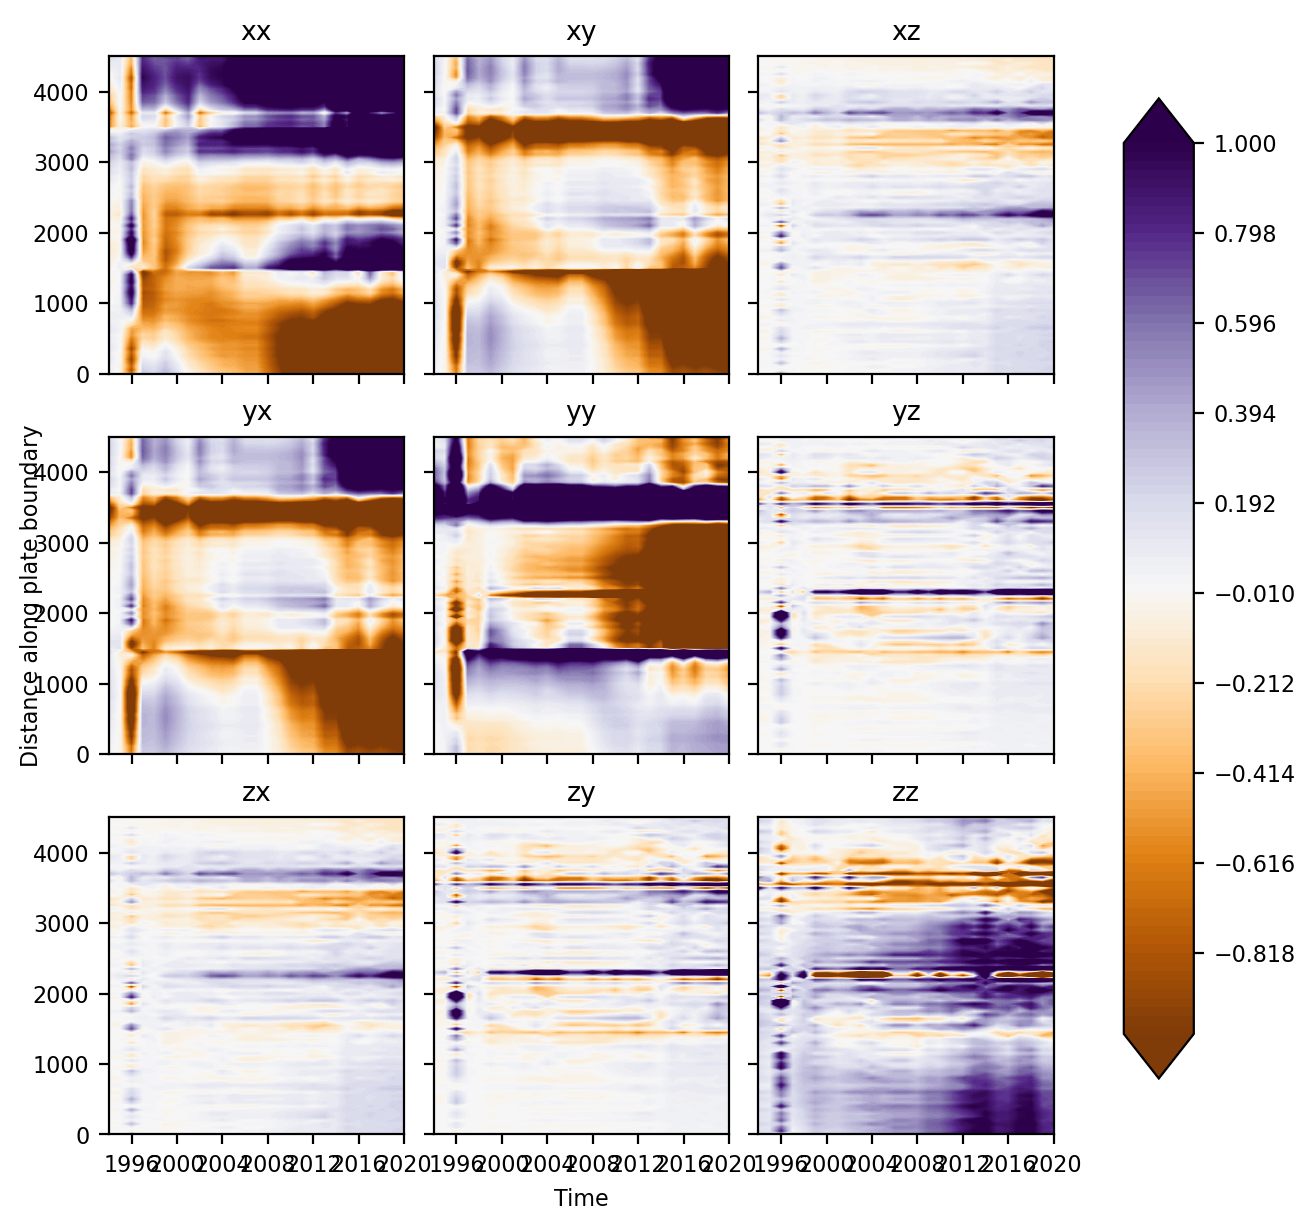

In [18]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7), sharex=True, sharey=True)

xyz = ["x", "y", "z"]

im = [
    ax[i, j].contourf(
        date_range[1:],
        np.arange(len(rate_grid)) * PLATE_BOUNDARY_STEP_SIZE/1000,
        strain_at_plate_boundary_grid[:, :, i, j],
        cmap="PuOr",
        levels=np.linspace(-1, 1, 100),
        extend="both",
        extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    )
    for i in range(3)
    for j in range(3)
][0]

[ax[i, j].set_title(f"{xyz[i]}{xyz[j]}") for i in range(3) for j in range(3)]

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
plt.xlabel("Time")
plt.ylabel("Distance along plate boundary")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.subplots_adjust(wspace=0.1, hspace=0.2)


In [19]:
def get_normal_strain(epsilon, p1, p2):
    horizontal_strain = epsilon[:-1, :-1]
    rotation90 = np.array(
        [
            [0, -1],
            [1, 0],
        ]
    )
    delta_r = p2 - p1
    unit_normal = rotation90 @ delta_r / np.sqrt(np.sum(delta_r * delta_r))
    return (horizontal_strain @ unit_normal).T @ (unit_normal)

# normal_strain_grid = np.empty_like(rate_grid)
normal_strain_grid = []
for i in np.arange(strain_at_plate_boundary_grid.shape[0] - 1):
    normal_strain_row = []
    for j in np.arange(strain_at_plate_boundary_grid.shape[1]):
        normal_strain_row.append(
            get_normal_strain(
                epsilon=strain_at_plate_boundary_grid[i, j, :, :],
                p1=np.array(
                    [[interp_merged_boundary.xy[1][i], interp_merged_boundary.xy[0][i]]]
                ).T,
                p2=np.array(
                    [
                        [
                            interp_merged_boundary.xy[1][i + 1],
                            interp_merged_boundary.xy[0][i + 1],
                        ]
                    ]
                ).T,
            ).squeeze()
        )
    normal_strain_grid.append(normal_strain_row)

normal_strain_grid = np.array(normal_strain_grid)


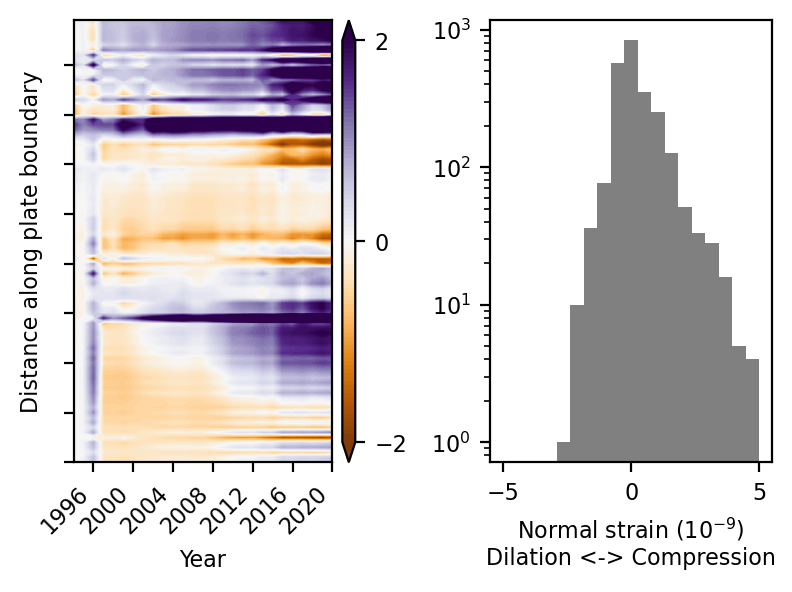

In [20]:

color_range = [-2, 2]
fig, AX = plt.subplots(1, 2, dpi=200, figsize=(4, 3))

ax = AX[0]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid) - 1) * PLATE_BOUNDARY_STEP_SIZE/1000,
    normal_strain_grid,
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")
for label in ax.get_xticklabels(which="major"):
    label.set(rotation=45, horizontalalignment="right")


ax.set_ylabel("Distance along plate boundary")
ax.set_yticklabels([])

ax = AX[1]
ax.hist(
    normal_strain_grid[:-1, :].flatten(),
    bins=np.linspace(-5, 5, 20),
    log=True,
    color="grey",
)
ax.set_xlabel("Normal strain $(10^{-9}$)\nDilation <-> Compression")

plt.tight_layout()


Figure: Space-time variations in the normal strain assuming a vertical plate boundary.

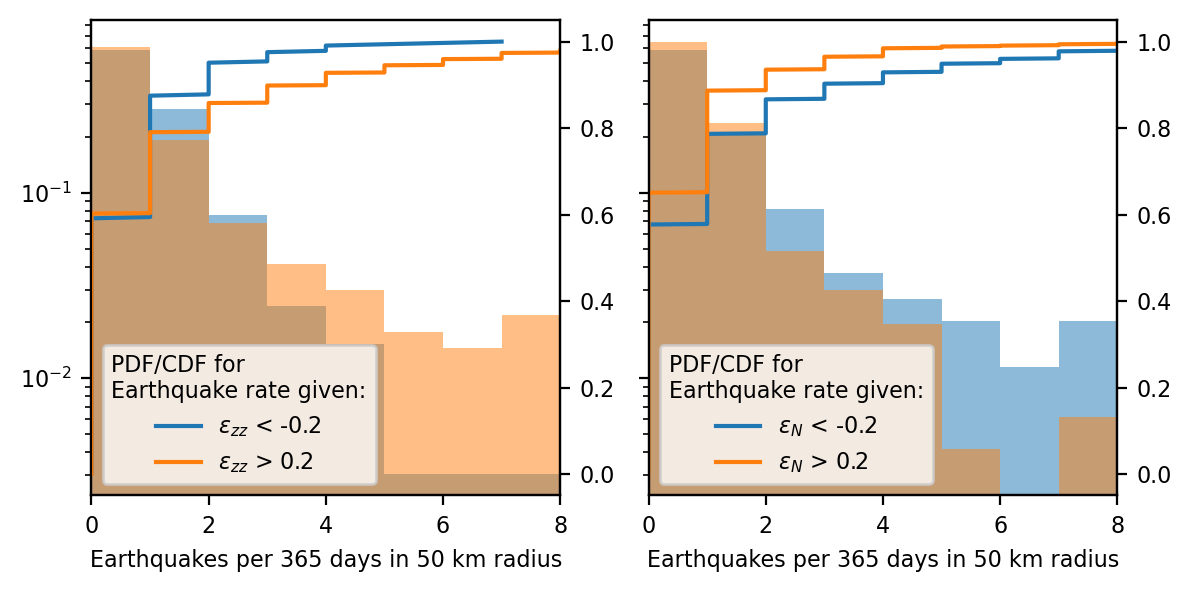

In [21]:
hist_kwargs = {"alpha": 0.5, "density": True}

xlabel = f"Earthquakes per {delta_t.days} days in {WINDOW_SIZE} km radius"
data_label = "Strain rate"


def plot_summary(
    x,
    y,
    y_threshold=0,
    ax=None,
    kwargs=hist_kwargs,
    xlabel=xlabel,
    base_label=data_label,
):
    bins = np.arange(
        *np.quantile(x, (0, 0.99)),
    )

    x2 = x[y > y_threshold]
    x1 = x[y < -y_threshold]

    if kwargs is None:
        kwargs = {}

    kwargs.update(
        {
            "bins": bins,
            "log": True,
            "density": True,
        }
    )

    ax.hist(x1, label=f"{base_label} < {-y_threshold}", **kwargs, color=f"C0")
    ax.hist(x2, label=f"{base_label} > {y_threshold}", **kwargs, color=f"C1")

    axb = ax.twinx()
    axb.plot(
        np.sort(x1),
        np.linspace(0, 1, len(x1) + 1)[1:],
        label=f"{base_label} < {-y_threshold}",
        color=f"C0",
    )
    axb.plot(
        np.sort(x2),
        np.linspace(0, 1, len(x2) + 1)[1:],
        label=f"{base_label} > {y_threshold}",
        color=f"C1",
    )
    axb.set_xlim(np.min(bins), np.max(bins))

    ax.set_xlabel(xlabel)

    lg = axb.legend()
    lg.set_title("PDF/CDF for\nEarthquake rate given:")


fig, AX = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)

ax = AX[0]
ii = 2
plot_summary(
    rate_grid.flatten(),
    strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{zz}$",
    ax=ax,
)

ax = AX[1]
plot_summary(
    rate_grid[:-1, :].flatten(),
    normal_strain_grid.flatten(),
    y_threshold=0.2,
    base_label=r"$\epsilon_{N}$",
    ax=ax,
)
plt.tight_layout()


**Figure**: Comparison of the PDF for the rate of earthquake during periods with negative and positive vertical strain along the plate boundary. I find it diffucult to interpret a meaningful signal from this alone.

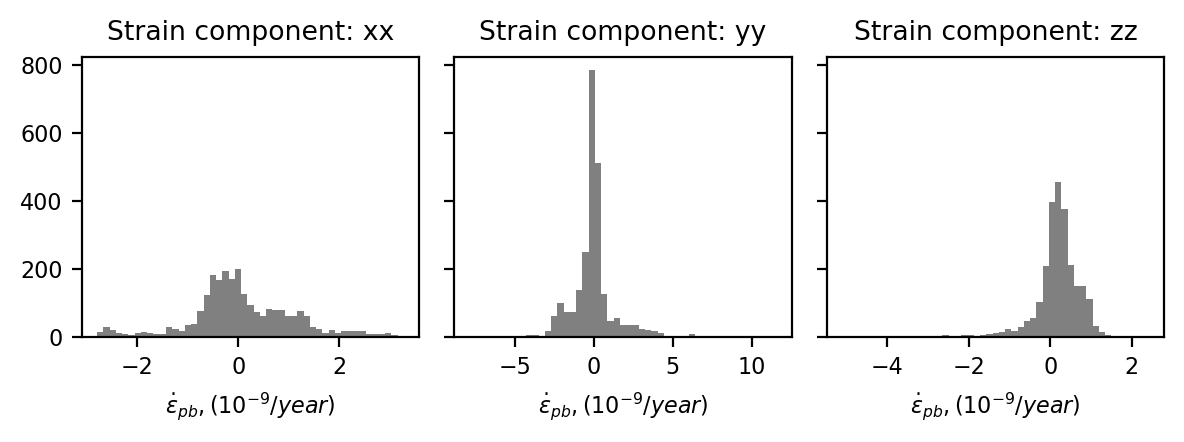

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.25), sharey=True)
for ii, iax in enumerate(ax):
    range_95th_percentile = np.percentile(
        strain_at_plate_boundary_grid[:, :, ii, ii].flatten(), [0.01, 99.99]
    )
    iax.hist(
        strain_at_plate_boundary_grid[:, :, ii, ii].flatten(),
        bins=np.linspace(*range_95th_percentile, 50),
        color="grey",
    )
    iax.set_xlabel(r"$\dot{\epsilon}_{pb}, (10^{-9}/year)$")
    iax.set_title(f"Strain component: {['xx','yy','zz'][ii]}")

plt.tight_layout()


**Figure**: GrGIA at the Atlantic mid ocean ridge.

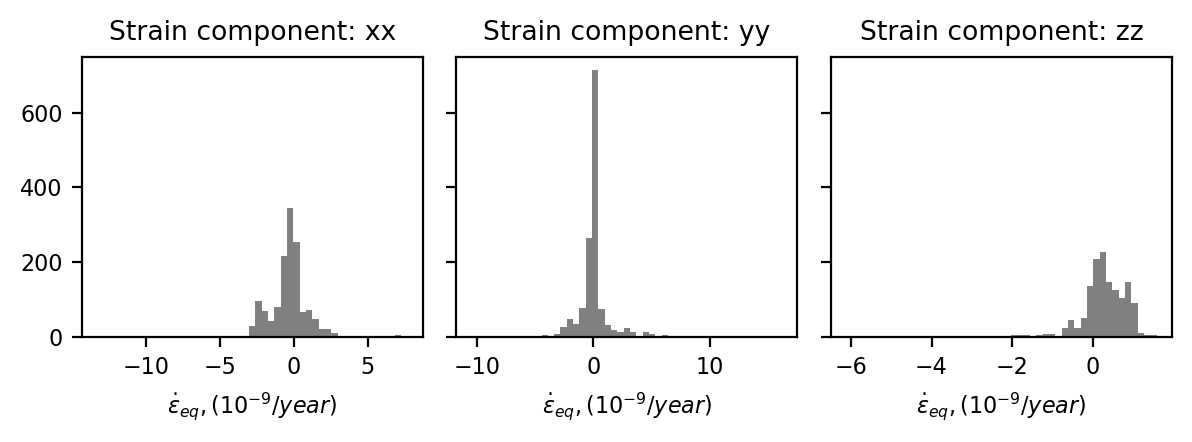

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.25), sharey=True)
for ii, iax in enumerate(ax):
    range_95th_percentile = np.percentile(
        strain_at_earthquake_with_time[:, ii, ii], [0.01, 99.99]
    )
    iax.hist(
        strain_at_earthquake_with_time[:, ii, ii],
        bins=np.linspace(*range_95th_percentile, 50),
        color="grey",
    )
    iax.set_xlabel(r"$\dot{\epsilon}_{eq}, (10^{-9}/year)$")
    iax.set_title(f"Strain component: {['xx','yy','zz'][ii]}")

plt.tight_layout()


**Figure**: GrGIA at earthquake locations

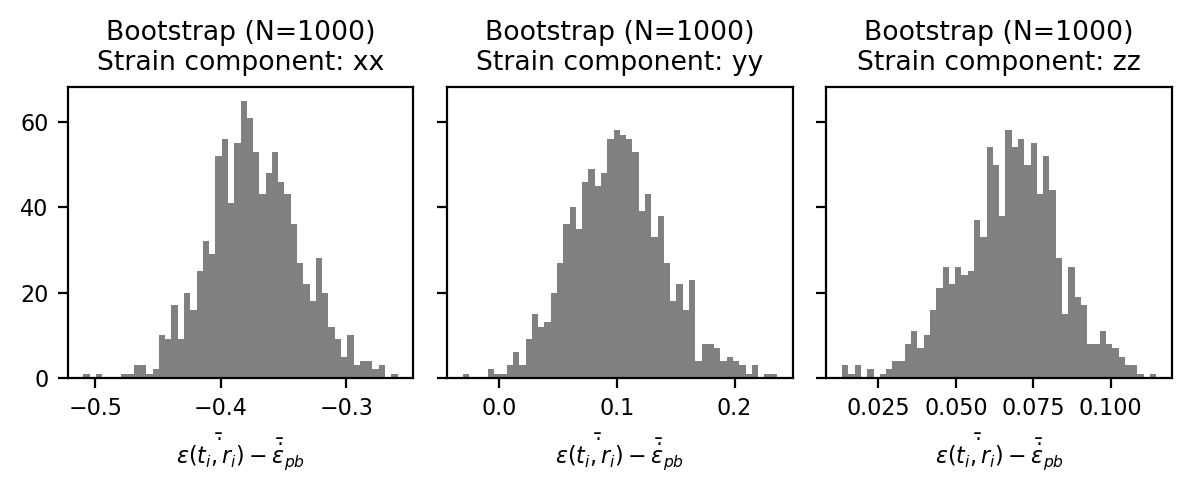

In [24]:
number_of_bootstrap_samples = 1000
fig, ax = plt.subplots(1, 3, figsize=(3 * 2, 2.5), dpi=200, sharey=True)

for ii, iax in enumerate(ax):
    mean_pb_strain = np.mean(strain_at_plate_boundary_grid[:, :, ii, ii].flatten())
    iax.hist(
        bootstrap_statistic(
            strain_at_earthquake_with_time[:, ii, ii] - mean_pb_strain,
            np.mean,
            boot=number_of_bootstrap_samples,
        ),
        bins=50,
        color="grey",
    )
    iax.set_xlabel(r"$\bar{\dot{\epsilon(t_i,r_i)}} - \bar{\dot{\epsilon}}_{pb}$")
    iax.set_title(
        f"Bootstrap (N={number_of_bootstrap_samples})\nStrain component: {['xx','yy','zz'][ii]}"
    )
plt.tight_layout()


**Figure**: Boostrap samples of the mean strain induced GrGIA at earthquake locations relative the plate boundary average. With reasonable statistical certainty, earthquakes tend to occur in areas/periods with higher strain. Correlation does not mean causation. This correspondance may instead result from the generally decreasing trend in seismicity towards the pole, which I interpret to be related to the decreasing spreading rate as the boudary approaches the Euler pole.

Text(0.5, 0, 'Latitude')

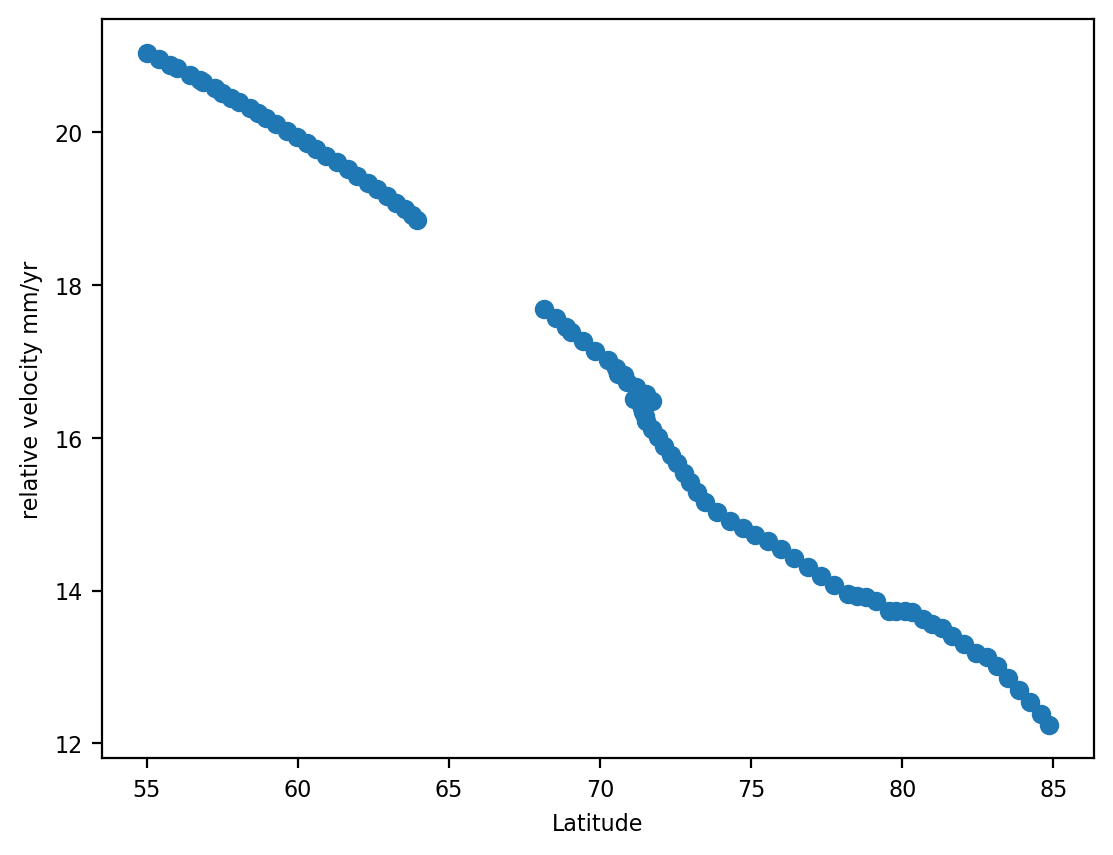

In [25]:
NA_pole = [48.709, -78.167, 0.7486]  # deg/MA - DeMets et al. [1994]
EU_pole = [61.066, -85.819, 0.8591]  # deg/MA - DeMets et al. [1994]


def get_spreading_rate(
    lat: np.ndarray = None,
    lon: np.ndarray = None,
    pole1: list[float, float, float] = NA_pole,
    pole2: list[float, float, float] = EU_pole,
) -> np.ndarray:
    """Gets the relative plate rate at a plate boundary for each lat lon pair given two euler poles

    The `pole` contains the **** lon, lat **** and angular roation rate (assumed to be in deg/MA). Note that a relatively exhaustive list of pole can be found in the following link:
    http://peterbird.name/oldFTP/PB2002/PB2002_poles.dat.txt

    Returns the spreading rate in km/Ma (or, equivalently mm/yr)

    """

    pole1, pole2, lat, lon = map(np.radians, [pole1, pole2, lat, lon])

    earth_radius_km = 6367
    locations = np.column_stack((lat, lon, np.ones_like(lat) * earth_radius_km))

    cartesian = lambda p: np.array(
        [
            p[:, 2] * np.cos(p[:, 0]) * np.cos(p[:, 1]),
            p[:, 2] * np.cos(p[:, 0]) * np.sin(p[:, 1]),
            p[:, 2] * np.sin(p[:, 0]),
        ]
    )
    omega1, omega2, r = map(
        cartesian, [np.expand_dims(pole1, 0), np.expand_dims(pole2, 0), locations]
    )

    omega = omega1 - omega2

    v = np.cross(omega.T, r.T)

    return np.sqrt(np.sum(v * v, 1))


plt.scatter(
    interp_merged_boundary.xy[1],
    get_spreading_rate(
        lat=interp_merged_boundary.xy[1], lon=interp_merged_boundary.xy[0]
    ),
)
plt.ylabel("relative velocity mm/yr")
plt.xlabel("Latitude")


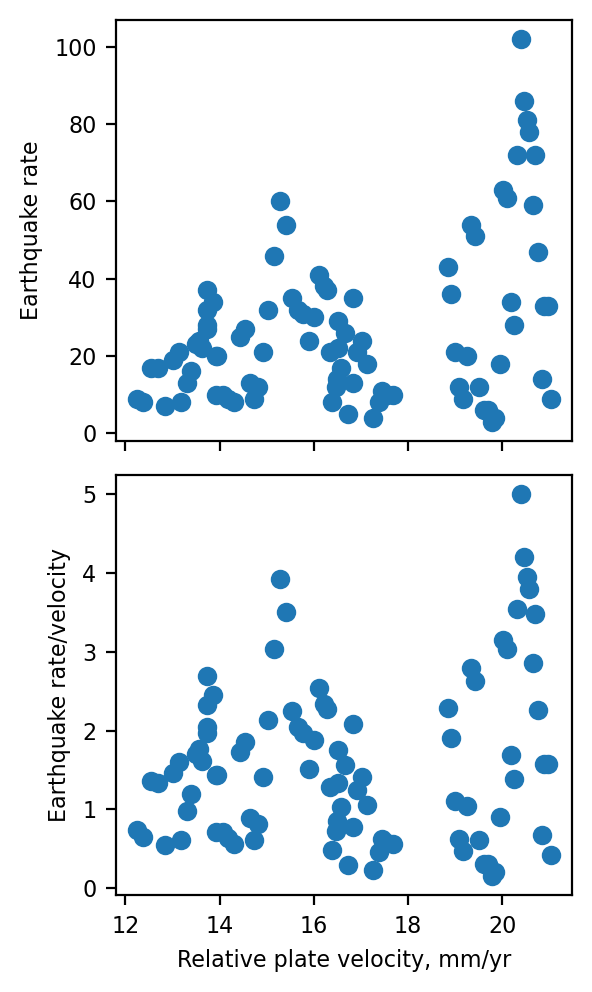

In [26]:
plate_boundary_velocity = get_spreading_rate(
    lat=interp_merged_boundary.xy[1], lon=interp_merged_boundary.xy[0]
)

fig, AX = plt.subplots(2, 1, figsize=(3, 5), sharex=True)

ax = AX[0]
ax.scatter(plate_boundary_velocity, rate)
ax.set_ylabel("Earthquake rate")

ax = AX[1]
ax.scatter(plate_boundary_velocity, rate / plate_boundary_velocity)
ax.set_xlabel("Relative plate velocity, mm/yr")
ax.set_ylabel("Earthquake rate/velocity")

plt.tight_layout()


In [27]:
np.mean(normal_strain_grid, axis=1).shape

(90,)

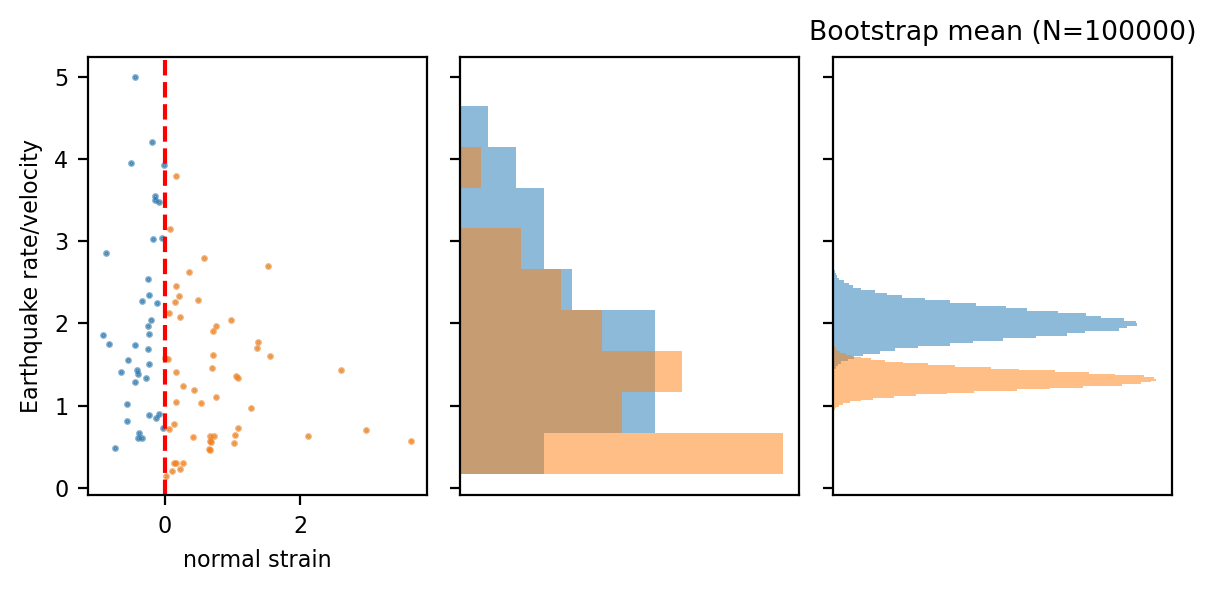

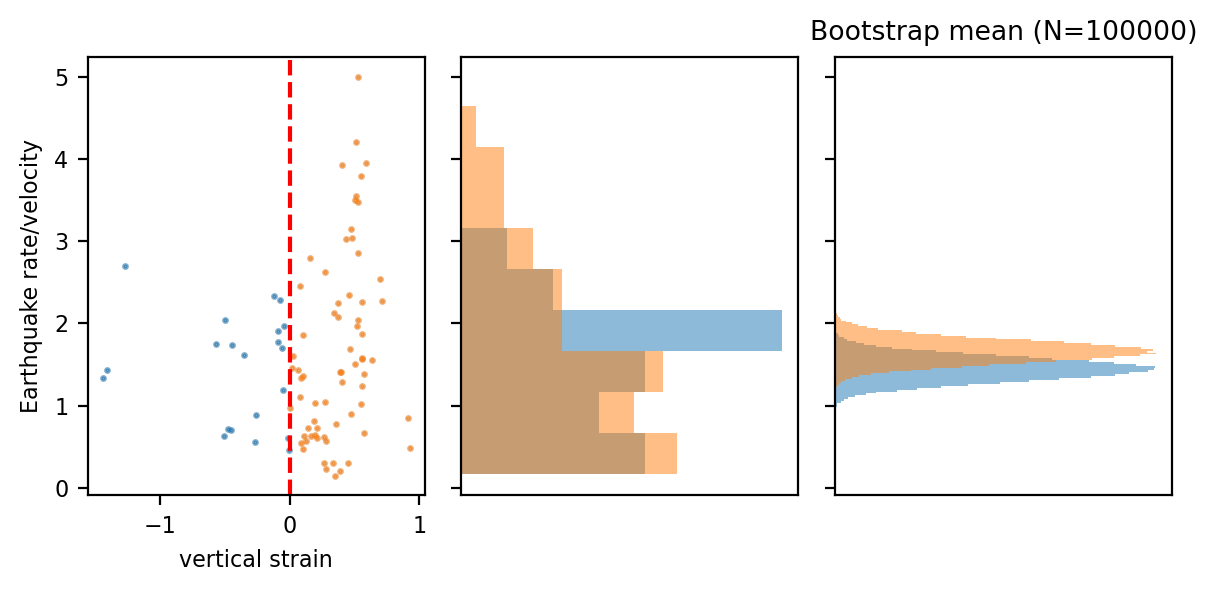

In [28]:
def summary_plot(x,y,theshold, data_label=None):
    fig, AX = plt.subplots(1, 3, sharey=True, figsize=(6, 3))
    ax = AX[0]

    positive_index = x > theshold
    negative_index = x < -theshold
    ax.scatter(x, y, s=2, alpha=0.1, c='k')
    ax.scatter(x[negative_index], y[negative_index], s=2, alpha=0.5)
    ax.scatter(x[positive_index], y[positive_index], s=2, alpha=0.5)
    ax.set_xlabel(f"{data_label}")
    ax.set_ylabel("Earthquake rate/velocity")
    ax.axvline(0, c="r", ls="--")

    ax = AX[1]
    range_95th_percentile = np.percentile(y, [0.5, 99.5])
    bins = np.linspace(*range_95th_percentile, 10)
    ax.hist(
        y[negative_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.5,
        label="strain<{theshold}".format(theshold=-theshold),
        density=True,
    )
    ax.hist(
        y[positive_index],
        bins=bins,
        orientation="horizontal",
        alpha=0.5,
        label="strain>{theshold}".format(theshold=theshold),
        density=True,
    )

    ax.set(
        xticks=[],
    )

    ax = AX[2]
    number_of_bootstrap_samples = 100000
    [ax.hist(
        bootstrap_statistic(
            y[i],
            np.mean,
            boot=number_of_bootstrap_samples,
        ),
        orientation="horizontal",
        alpha=0.5,
        bins=50,
    ) for i in [negative_index, positive_index]
    ]

    ax.set(
        xticks=[],
        title="Bootstrap mean (N={number_of_bootstrap_samples})".format(
            number_of_bootstrap_samples=number_of_bootstrap_samples
        ),
    )

    plt.tight_layout()

summary_plot(np.mean(normal_strain_grid, axis=1), (rate / plate_boundary_velocity)[1:], 0, data_label = "normal strain")
summary_plot(np.mean(strain_at_plate_boundary_grid[:, :, 2, 2][1:], axis=1), (rate / plate_boundary_velocity)[1:], 0, data_label = "vertical strain")


**Figure**: Time averaged strain rate versus the normalized rate of seismicity. It does seem that, in agreement with expectation, the rate of seismicity tends to be higher in areas more GrGIA dilation (blue).

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/3405619808.py:2: RuntimeWarning: divide by zero encountered in log10
  log_normalized_rate_grid = np.log10((rate_grid / velocity_grid)[1:, :])


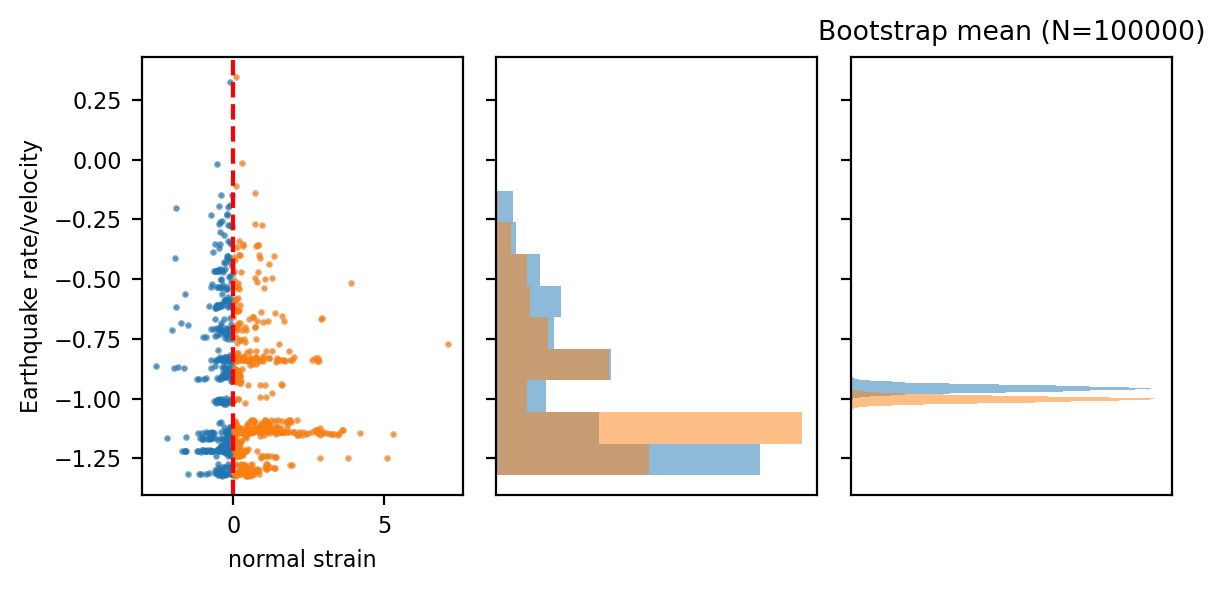

In [29]:
velocity_grid = np.expand_dims(plate_boundary_velocity, 1) * np.ones_like(strain_years)
log_normalized_rate_grid = np.log10((rate_grid / velocity_grid)[1:, :])

not_zero = ((rate_grid / velocity_grid)[1:, :]) > 0
summary_plot(normal_strain_grid[not_zero], log_normalized_rate_grid[not_zero], 0, data_label = "normal strain")

Figure: NOTE the y-axis is log-scaled. 

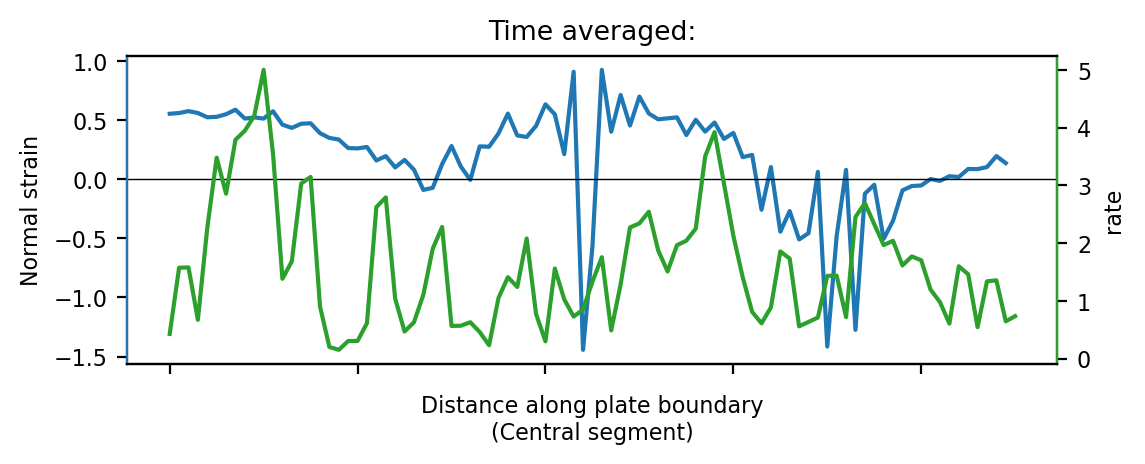

In [30]:
fig, ax = plt.subplots(dpi=200, figsize=(6, 2))

ax.plot(strain_at_plate_boundary_grid[:, :, 2, 2].mean(axis=1)[1:])
ax.axhline(0, c="k", lw=0.5)


axc = ax.twinx()
# axc.plot(np.array(space_statistics["b-value (b-positive)"]), c="C2")
axc.plot(rate / plate_boundary_velocity, c="C2")
axc.spines["right"].set_edgecolor("C2")
axc.spines["left"].set_edgecolor("C0")
axc.set_ylabel("rate")


ax.set(
    title="Time averaged:",
    xticklabels=[],
    xlabel="Distance along plate boundary\n(Central segment)",
    ylabel = "Normal strain",
);


/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_74654/2229333182.py:94: UserWarning: FixedFormatter should only be used together with FixedLocator
  [iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]


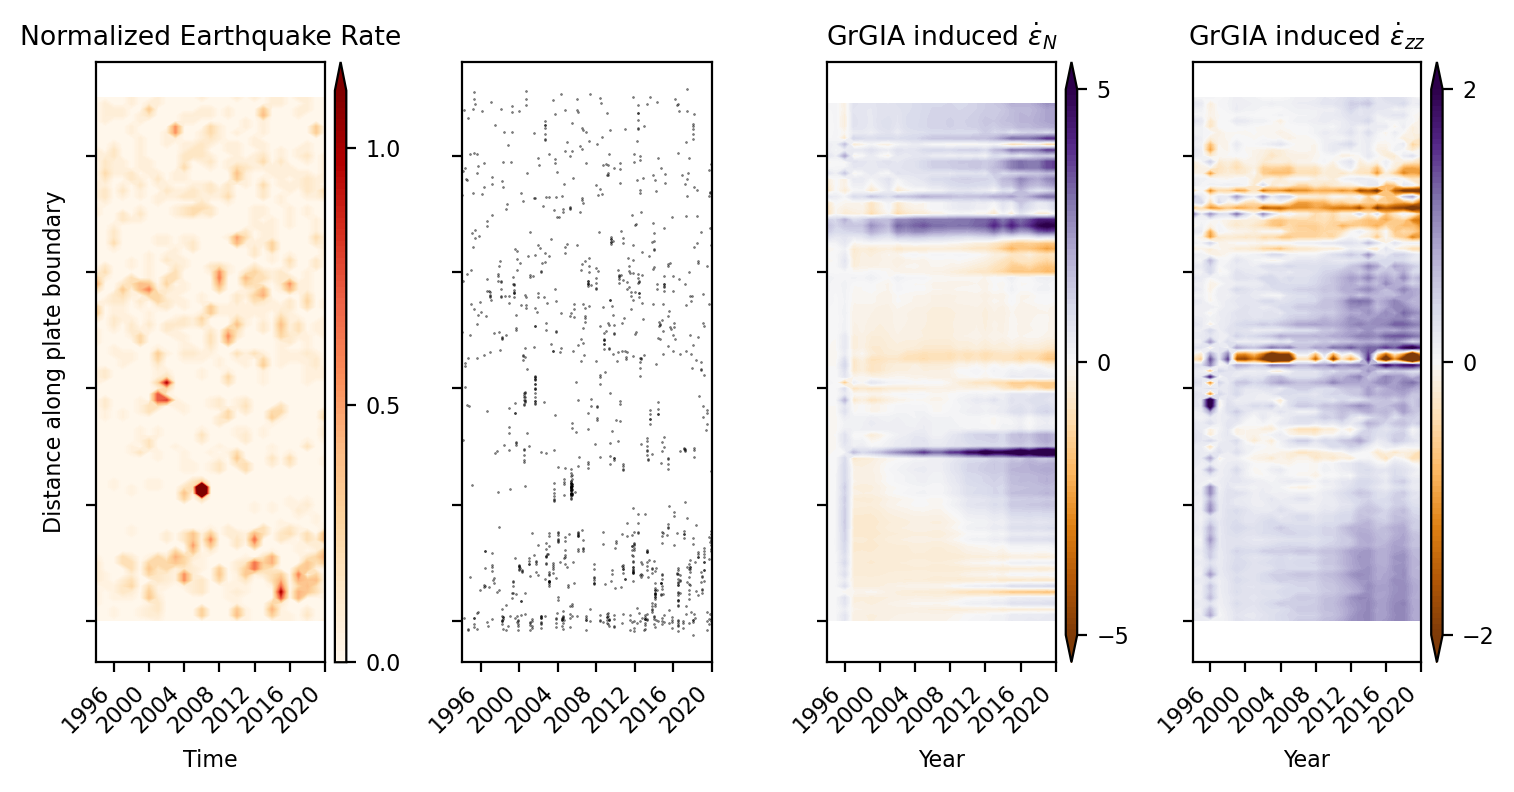

In [31]:
fig, AX = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(7.5, 4))
    
ax = AX[0]
# plot the rate_grid of events over time and space
max_level = 0.5 * (rate_grid / velocity_grid).max()
levels = np.linspace((rate_grid / velocity_grid).min(), max_level, 100)
cf = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * PLATE_BOUNDARY_STEP_SIZE/1000,
    rate_grid / velocity_grid,
    levels=levels,
    cmap="OrRd",
    vmax=max_level,
    extend="max",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
)
x_lim = ax.get_xlim()

ax.set_xlabel("Time")
ax.set_ylabel("Distance along plate boundary")
ax.margins(x=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cf, cax=cax, ticks=np.arange(0, max_level, 0.5))

ax.set_title("Normalized Earthquake Rate")


ax = AX[1]
ax.scatter(
    catalog.time, catalog.distance_along_boundary/1000 + np.random.normal(0, 50, len(catalog)),
    color='black',
    s=0.5,
    lw=0.2,
    alpha=0.5, 
)

# ax.axhspan(4000, 5000, facecolor="k", alpha=0.1, label="Iceland")
# ax.axhspan(6500, 7500, facecolor="r", alpha=0.1, label="Svalbard")


ax = AX[1+1]
color_range = [-5, 5]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid) - 1) * PLATE_BOUNDARY_STEP_SIZE/1000,
    normal_strain_grid,
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])
ax.set_title(r"GrGIA induced $\dot{\epsilon}_N$")

ax = AX[2+1]
color_range = [-2, 2]
im = ax.contourf(
    date_range[1:],
    np.arange(len(rate_grid)) * PLATE_BOUNDARY_STEP_SIZE/1000,
    strain_at_plate_boundary_grid[:, :, 2, 2],
    levels=np.linspace(*color_range, 100),
    extend="both",
    extent=[0, rate_grid.shape[1], 0, rate_grid.shape[0]],
    cmap="PuOr",
)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, ticks=[color_range[0], 0, color_range[1]])

ax.set_xlabel("Year")


ax.set_yticklabels([])

ax.set_title(r"GrGIA induced $\dot{\epsilon}_{zz}$")

# [iax.scatter(
#     plate_boundary_catalog.time, plate_boundary_catalog.distance_along_boundary/10000,
#     color='k',
#     s=1
# ) for iax in AX]

[iax.set(xlim=x_lim) for iax in AX]
[iax.set_xticklabels(iax.get_xticklabels(), rotation = 45, ha="right") for iax in AX]

plt.tight_layout()


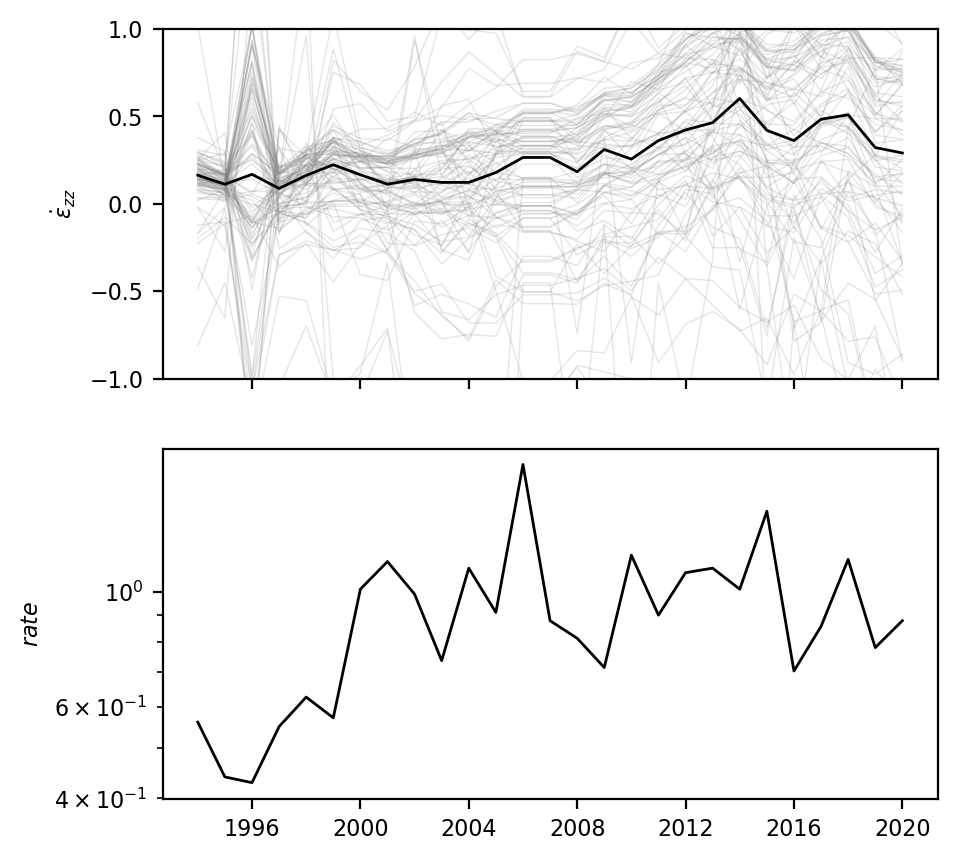

In [36]:
fig, ax = plt.subplots(2,1,sharex=True,figsize=(5,5))
ax[0].plot(date_range[1:],strain_at_plate_boundary_grid[:, :, 2, 2].T,lw=0.5,color='grey',alpha=0.2)
ax[0].plot(date_range[1:],np.median(strain_at_plate_boundary_grid[:, :, 2, 2].T,axis=1),lw=1,color='k')
ax[0].set_ylim([-1,1])
ax[0].set_ylabel(r"$\dot{\epsilon}_{zz}$")
#ax[1].plot(date_range[1:],rate_grid.T,lw=0.5,color='grey',alpha=0.5);
ax[1].plot(date_range[1:],np.mean(rate_grid.T,axis=1),lw=1,color='k');
ax[1].set_ylabel(r"$rate$")
ax[1].set_yscale('log')
